In [153]:
# Using cv2 weighted overlay

In [154]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv

In [155]:
drop_out = False
n_classes = 2
split = 0
image_num = 120
model_type = "clam_sb"
model_size = 'small'
exp_code = "exp_6" + "_s1"
results_dir = "image_sets/results"

data_dir = "image_sets/original/"
image_ext = ".tif"
patch_dir = "image_sets/patches/"
feat_dir = "image_sets/features/"
actual_feat_dir = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/"

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
heatmap_dict = "split_"+str(split)+"_heatmap_dict.pkl"

In [156]:
patch_size = (256, 256)
alpha = 1
beta = 0.5
gamma = 0.0
cmap='coolwarm'

In [157]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, heatmap_dict))

In [158]:
image_file = heatmap_dict[image_num]

image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

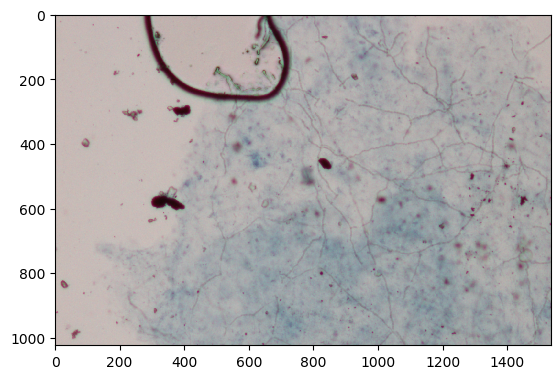

In [159]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

img_path = os.path.join(data_dir, image_name+image_ext)
# orig_img = np.array(Image.open(img_path))
# orig_img = orig_img[0:1024, 0:1536] # No left-overs

orig_img = cv.imread(img_path)
orig_img = orig_img[0:1024, 0:1536] # No left-overs
plt.imshow(orig_img)

In [160]:
scores = attention_scores[0].copy()
scores = [float(x) for x in scores]
percentiles = []
for score in scores:
    percentile = percentileofscore(scores, score)
    percentiles.append(percentile/100)
print(scores)
print()
print(percentiles)

[0.008044722490012646, 0.1656629890203476, 0.018242299556732178, 0.04720555990934372, 0.041444309055805206, 0.01588231325149536, 0.023878352716565132, 0.01777002587914467, 0.03142225742340088, 0.04243288189172745, 0.022105365991592407, 0.04934028163552284, 0.005035074893385172, 0.046963129192590714, 0.04974987730383873, 0.06269969046115875, 0.08352341502904892, 0.04895136132836342, 0.019992424175143242, 0.03554447740316391, 0.03881416842341423, 0.04163755476474762, 0.0482732355594635, 0.035384226590394974]

[0.08333333333333334, 1.0, 0.20833333333333331, 0.7083333333333333, 0.5416666666666666, 0.125, 0.33333333333333337, 0.16666666666666669, 0.375, 0.625, 0.2916666666666667, 0.8333333333333333, 0.04166666666666667, 0.6666666666666667, 0.875, 0.9166666666666667, 0.9583333333333333, 0.7916666666666667, 0.25, 0.45833333333333337, 0.5, 0.5833333333333334, 0.75, 0.41666666666666663]


In [161]:
# heatmap_mask = Image.new("RGB", (1536, 1024), (0, 0, 0))
# heatmap_mask = cv.cvtColor(np.array(heatmap_mask), cv.COLOR_RGB2BGR)

In [162]:
heatmap_mask = np.zeros([1024, 1536, 3])

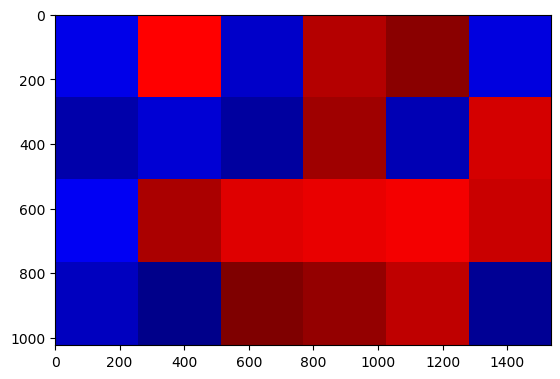

In [163]:
threshold = 0.5

for index, score in enumerate(percentiles):
    x = 256 * coords_list[0][0][index].item() # Top left corner
    y = 256 * coords_list[0][1][index].item() # Top left corner
#     print("Score, x, y:", score, x, y)
#     print(x, y, x+patch_size[0], y+patch_size[1])
    
    if (score >= threshold):
        heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], 0] = score
    else:
        heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], 2] = 1-score

# print(heatmap_mask)
plt.imshow(heatmap_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


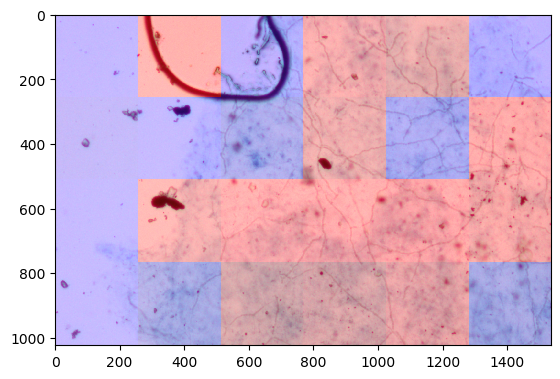

In [164]:
img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".jpg")

# print(orig_img.shape)
# print(heatmap_mask.shape)

orig_img = orig_img.astype(np.float32)
orig_img /= 255

# print(orig_img.max())
# print(heatmap_mask.max())

alpha = 1
beta = 0.4
gamma = 0.0

# heatmap_mask = cv.cvtColor(np.array(heatmap_mask).astype(np.uint8), cv.COLOR_RGB2BGR)

img_heatmap = cv.addWeighted(orig_img, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
if not cv.imwrite(img_heatmap_filename, img_heatmap):
     raise Exception("Could not save the heatmap", img_heatmap_filename)
plt.imshow(img_heatmap)